In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install segmentation-models-pytorch
!pip install torchvision
!pip install scikit-learn
!pip install seaborn

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=09656f3cdb4a173b2c6492f5a4f632b98e59205aa159e4350f62bcac58b67c99
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=7a69e39b9fa27a3bf23e51ba4844f47aede578e975df5e3e8b8a30c002a0c43f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [3]:
# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                             std=[0.229, 0.224, 0.225])   # ImageNet std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                             std=[0.229, 0.224, 0.225])   # ImageNet std
    ]),
}


In [4]:
# Paths to the dataset
train_dir = '/content/drive/MyDrive/MRI-Classification/Training'
val_dir = '/content/drive/MyDrive/MRI-Classification/Testing'

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=data_transforms['train'])
val_dataset = ImageFolder(root=val_dir, transform=data_transforms['val'])

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
print(f'Classes: {class_names}')


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


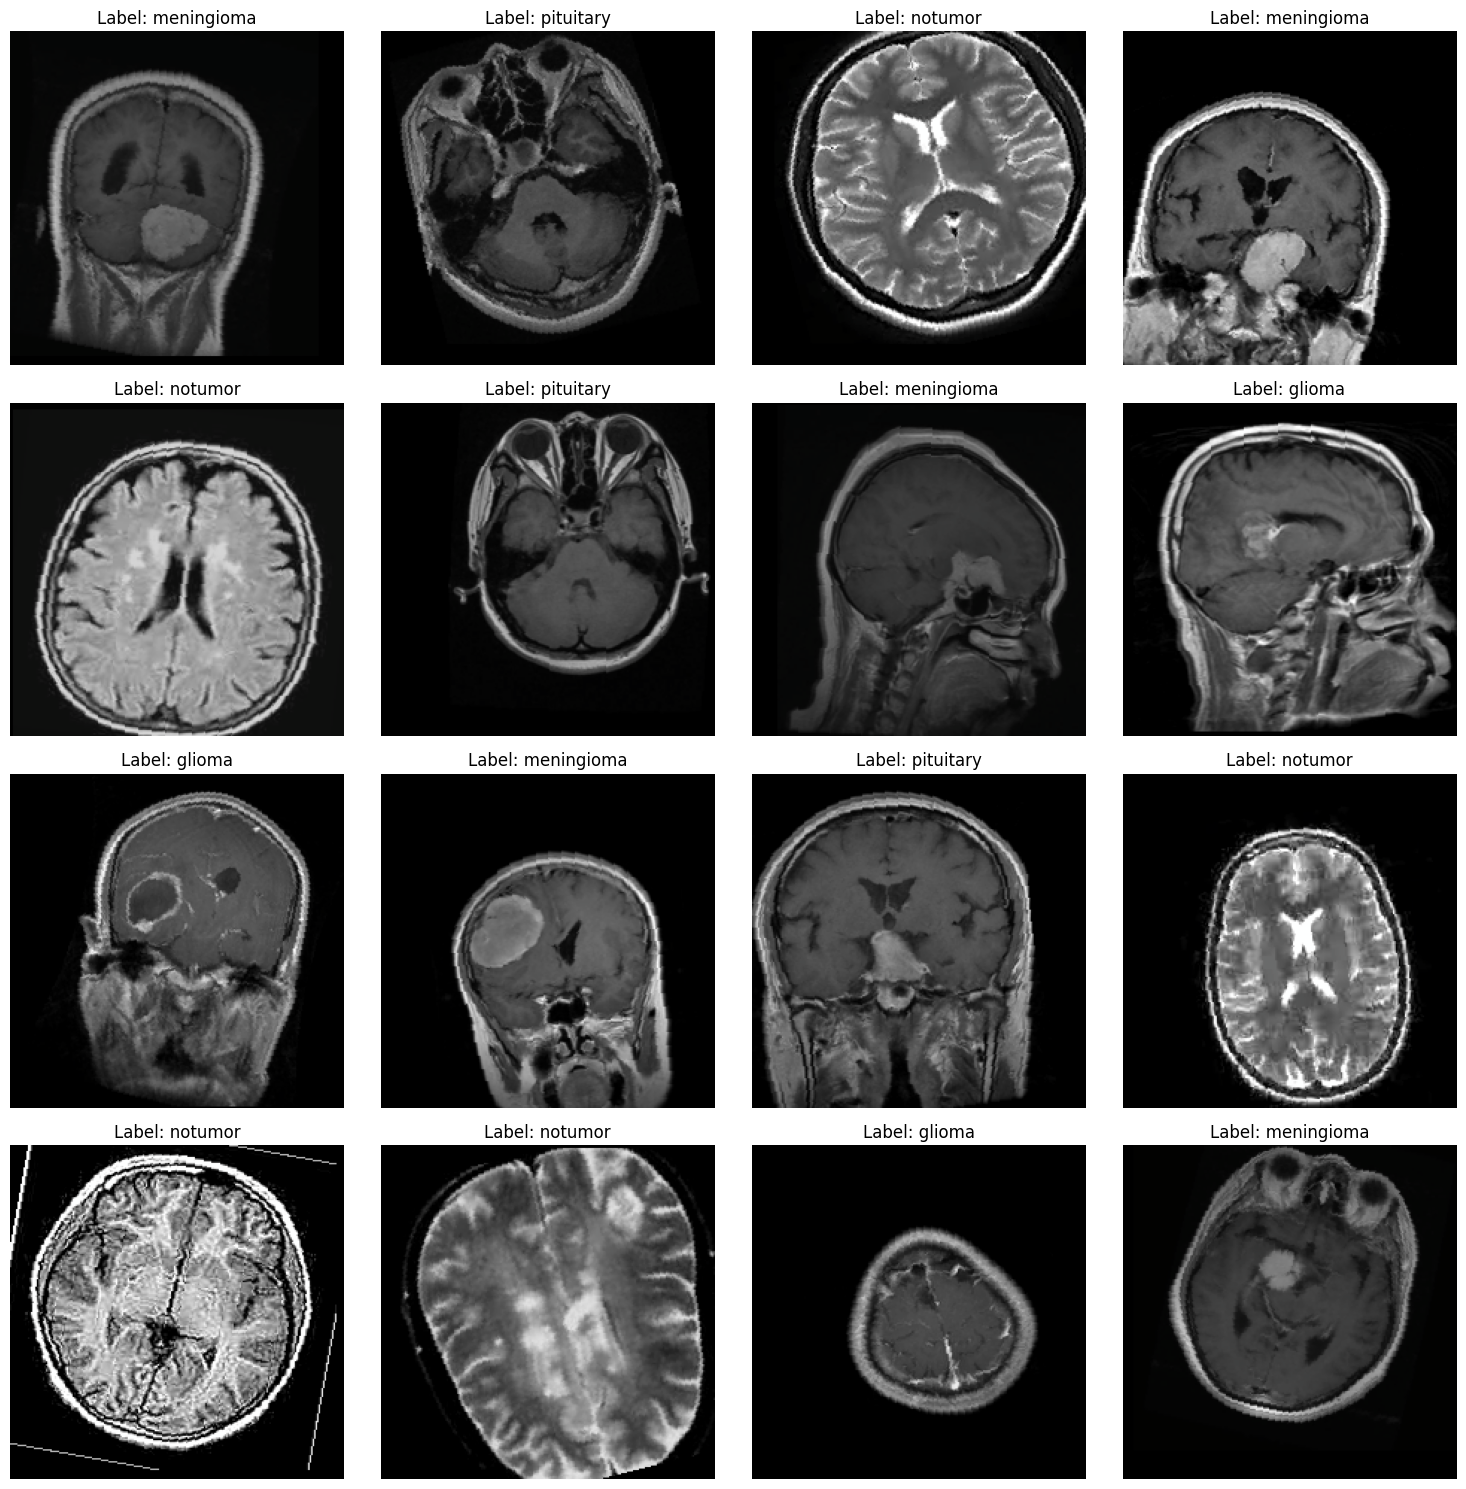

In [7]:
# 4.3 Visualize Sample Images

import torchvision

# Function to display images
def imshow_grid(images, labels, class_names, cols=4, figsize=(15, 15)):
    """
    Displays a grid of images with their labels.

    Args:
        images (torch.Tensor): Batch of images.
        labels (torch.Tensor): Corresponding labels.
        class_names (list): List of class names.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.
    """
    # Convert images to numpy arrays and denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = images.numpy().transpose((0, 2, 3, 1))  # Convert to (Batch, H, W, C)
    images = (images * std + mean).clip(0, 1)  # Denormalize

    # Determine grid size
    num_images = len(images)
    cols = cols
    rows = int(np.ceil(num_images / cols))

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i in range(rows * cols):
        ax = axes[i]
        if i < num_images:
            ax.imshow(images[i])
            ax.set_title(f'Label: {class_names[labels[i]]}')
        ax.axis('off')  # Hide axes for clarity

    plt.tight_layout()
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Corrected line using next()

# Display the images in a grid
imshow_grid(images[:16], labels[:16], class_names, cols=4, figsize=(15, 15))


In [22]:
# 5.1 Define the Classification Model (Updated)

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class UNetClassifier(nn.Module):
    def __init__(self, num_classes, encoder_name='resnet34', pretrained=True):
        """
        Initializes the UNetClassifier with a pre-trained encoder and a classification head.

        Args:
            num_classes (int): Number of target classes.
            encoder_name (str): Name of the encoder architecture.
            pretrained (bool): Whether to use ImageNet-pretrained weights.
        """
        super(UNetClassifier, self).__init__()

        # Initialize the pre-trained U-Net encoder
        self.encoder = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights='imagenet' if pretrained else None,
            in_channels=3,
            classes=0,  # No segmentation layers
            activation=None
        )

        # Retrieve the number of output channels from the encoder
        # This assumes that the encoder's out_channels attribute is a list
        encoder_out_channels = self.encoder.encoder.out_channels[-1]  # Use the last element
        # print(f'Encoder Output Channels: {self.encoder.encoder.out_channels}')
        # print(f'Final Encoder Output Channels: {encoder_out_channels}')

        # Define the classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(encoder_out_channels, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (Batch, Channels, Height, Width)

        Returns:
            torch.Tensor: Output logits of shape (Batch, num_classes)
        """
        # Extract features using the encoder
        features = self.encoder.encoder(x)  # Access the encoder part only

        # Check if features is a list and select the last feature map
        if isinstance(features, list):
            features = features[-1]  # Shape: (Batch, Channels, H, W)
            # print(f'Features shape after selecting last feature map: {features.shape}')
        else:
            pass  # Optionally handle other cases
            # print(f'Features shape: {features.shape}')

        # Pass through the classification head
        out = self.classifier(features)
        return out


In [23]:
# 5.2 Initialize the Model

# Number of classes
num_classes = 4  # e.g., glioma, meningioma, no tumor, pituitary

# Initialize the model
model = UNetClassifier(num_classes=num_classes, encoder_name='resnet34', pretrained=True)
model = model.to(device)
print(model)


UNetClassifier(
  (encoder): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [24]:
# 6.1 Define Loss Function

import torch.nn as nn

# Define loss function
criterion = nn.CrossEntropyLoss()
# 6.2 Define Optimizer

import torch.optim as optim

# Define optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)


In [25]:
# 7.1 Define Training and Validation Functions

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model.
        dataloader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        device (torch.device): Device to run the training on.

    Returns:
        float: Average loss for the epoch.
        float: Training accuracy for the epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    Validates the model.

    Args:
        model (nn.Module): The neural network model.
        dataloader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the validation on.

    Returns:
        float: Average loss for the epoch.
        float: Validation accuracy for the epoch.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [26]:
# 7.2 Initialize Training Parameters

# Number of epochs
num_epochs = 25

# Initialize history dictionaries to store loss and accuracy
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best validation accuracy for checkpointing
best_val_acc = 0.0

# Early stopping parameters
patience = 5
counter = 0


In [27]:
# 7.3 Training Loop (Updated)

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate after training
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Record the history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} '
          f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

    # Check if this is the best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_unet_classifier.pth')
        print(f'Best model saved with Val Acc: {best_val_acc:.4f}')
        counter = 0  # Reset counter if improvement
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break


Epoch [1/25] Train Loss: 0.6703 Train Acc: 0.7369 Val Loss: 0.5255 Val Acc: 0.7941
Best model saved with Val Acc: 0.7941
Epoch [2/25] Train Loss: 0.4901 Train Acc: 0.8164 Val Loss: 0.4882 Val Acc: 0.8124
Best model saved with Val Acc: 0.8124
Epoch [3/25] Train Loss: 0.4539 Train Acc: 0.8307 Val Loss: 0.5153 Val Acc: 0.8093
Epoch [4/25] Train Loss: 0.4320 Train Acc: 0.8388 Val Loss: 0.4638 Val Acc: 0.8223
Best model saved with Val Acc: 0.8223
Epoch [5/25] Train Loss: 0.4146 Train Acc: 0.8456 Val Loss: 0.4627 Val Acc: 0.8139
Epoch [6/25] Train Loss: 0.3923 Train Acc: 0.8536 Val Loss: 0.4132 Val Acc: 0.8444
Best model saved with Val Acc: 0.8444
Epoch [7/25] Train Loss: 0.3928 Train Acc: 0.8501 Val Loss: 0.4097 Val Acc: 0.8413
Epoch [8/25] Train Loss: 0.3708 Train Acc: 0.8592 Val Loss: 0.3916 Val Acc: 0.8474
Best model saved with Val Acc: 0.8474
Epoch [9/25] Train Loss: 0.3735 Train Acc: 0.8603 Val Loss: 0.4078 Val Acc: 0.8375
Epoch [10/25] Train Loss: 0.3827 Train Acc: 0.8549 Val Loss: 0.

In [28]:
# 8.1 Load the Best Model

# Initialize the model architecture
model = UNetClassifier(num_classes=num_classes, encoder_name='resnet34', pretrained=True)

# Load the saved state dictionary
model.load_state_dict(torch.load('/content/drive/MyDrive/best_unet_classifier.pth'))

# Move to device
model = model.to(device)

# Set to evaluation mode
model.eval()
print('Best model loaded successfully!')


<ipython-input-28-99e1105749b9>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/best_unet_classifier.pth'))


Best model loaded successfully!


Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.81      0.86       300
  meningioma       0.76      0.72      0.74       306
     notumor       0.92      0.96      0.94       405
   pituitary       0.86      0.96      0.91       300

    accuracy                           0.87      1311
   macro avg       0.87      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311



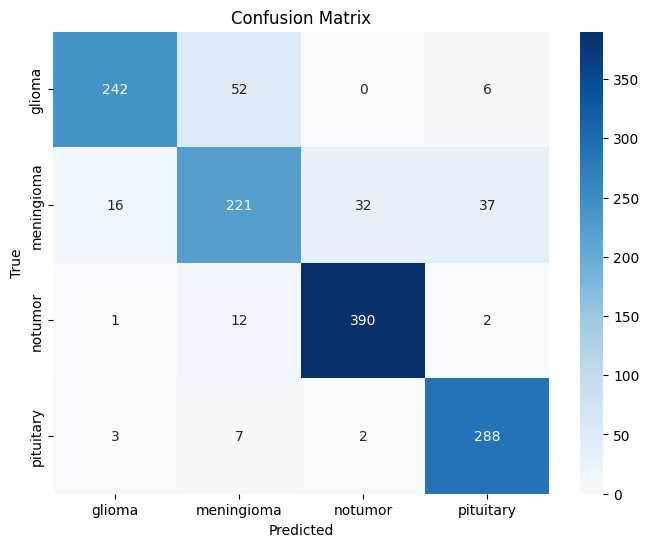

In [29]:
# 8.2 Detailed Evaluation Metrics

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def get_all_preds(model, dataloader, device):
    """
    Get all predictions and true labels from the dataloader.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for validation data.
        device (torch.device): Device to run the model on.

    Returns:
        list: Predicted class indices.
        list: True class indices.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Get predictions and true labels
y_preds, y_true = get_all_preds(model, val_loader, device)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


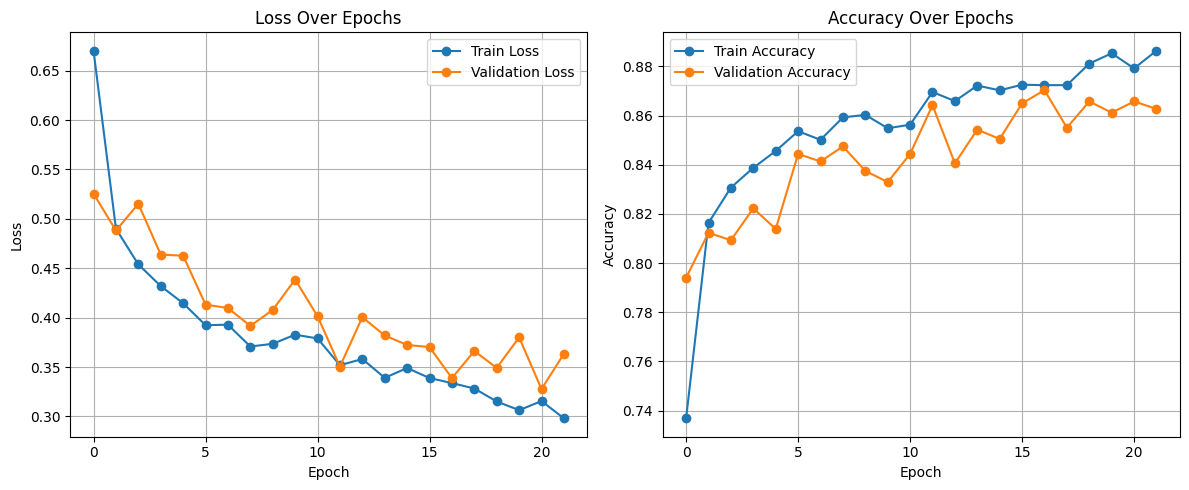

In [30]:
# 9. Visualize Training History

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [31]:
# 10.1 Save the Final Model

# Save the final model
torch.save(model.state_dict(), '/content/drive/MyDrive/final_unet_classifier.pth')
print('Final model saved successfully!')


Final model saved successfully!


In [32]:
# 10.2 Load the Model for Inference

# Initialize the model architecture
model = UNetClassifier(num_classes=num_classes, encoder_name='resnet34', pretrained=True)

# Load the saved state dictionary
model.load_state_dict(torch.load('/content/drive/MyDrive/final_unet_classifier.pth'))

# Move to device
model = model.to(device)

# Set to evaluation mode
model.eval()
print('Final model loaded successfully and ready for inference!')


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
<ipython-input-32-8dbe0cbe6073>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

Final model loaded successfully and ready for inference!


In [33]:
# 11.1 Define a Prediction Function

from PIL import Image

def predict_image(image_path, model, transform, device, class_names):
    """
    Predict the class of a single image using the trained model.

    Args:
        image_path (str): Path to the image.
        model (nn.Module): Trained model.
        transform (torchvision.transforms.Compose): Transformations to apply.
        device (torch.device): Device to perform computation on.
        class_names (list): List of class names.

    Returns:
        str: Predicted class name.
    """
    # Load image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image = transform(image).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    # Get predicted class
    pred_class = class_names[preds.item()]

    return pred_class


In [35]:
# 11.2 Use the Prediction Function

# Example image path (replace with your own image path)
example_image_path = '/content/drive/MyDrive/MRI-Classification/Testing/notumor/Te-noTr_0000.jpg'

# Predict the class
predicted_class = predict_image(example_image_path, model, data_transforms['val'], device, class_names)
print(f'Predicted Class: {predicted_class}')


Predicted Class: meningioma


In [38]:
# 11.3 Batch Prediction (Optional)

def predict_batch(image_paths, model, transform, device, class_names):
    """
    Predict the classes of multiple images using the trained model.

    Args:
        image_paths (list): List of image file paths.
        model (nn.Module): Trained model.
        transform (torchvision.transforms.Compose): Transformations to apply.
        device (torch.device): Device to perform computation on.
        class_names (list): List of class names.

    Returns:
        list: Predicted class names.
    """
    images = []
    for path in image_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    # Stack images into a batch
    images = torch.stack(images).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Get predicted classes
    pred_classes = [class_names[p.item()] for p in preds]

    return pred_classes

# Example batch of image paths (replace with your own image paths)
example_image_paths = [
    '/content/drive/MyDrive/MRI-Classification/Testing/notumor/Te-noTr_0001.jpg',
    '/content/drive/MyDrive/MRI-Classification/Testing/glioma/Te-gl_0011.jpg',
    '/content/drive/MyDrive/MRI-Classification/Testing/pituitary/Te-piTr_0002.jpg',
    '/content/drive/MyDrive/MRI-Classification/Testing/notumor/Te-no_0219.jpg'
]

# Predict the classes
predicted_classes = predict_batch(example_image_paths, model, data_transforms['val'], device, class_names)

# Display the predictions
for path, pred in zip(example_image_paths, predicted_classes):
    print(f'Image: {path} --> Predicted Class: {pred}')


Image: /content/drive/MyDrive/MRI-Classification/Testing/notumor/Te-noTr_0001.jpg --> Predicted Class: notumor
Image: /content/drive/MyDrive/MRI-Classification/Testing/glioma/Te-gl_0011.jpg --> Predicted Class: glioma
Image: /content/drive/MyDrive/MRI-Classification/Testing/pituitary/Te-piTr_0002.jpg --> Predicted Class: pituitary
Image: /content/drive/MyDrive/MRI-Classification/Testing/notumor/Te-no_0219.jpg --> Predicted Class: notumor


In [39]:
# 12.1 Extract Volumetric-like Features

import numpy as np

def extract_volumetric_features(model, dataloader, device):
    """
    Extract volumetric-like features (mean and std of feature maps) from the encoder.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on.

    Returns:
        np.ndarray: Extracted features (mean and std concatenated).
        np.ndarray: Corresponding labels.
    """
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            # Get features from the encoder
            features = model.encoder.encoder(inputs)  # Shape: (Batch, Channels, H, W)

            # Select the last feature map
            if isinstance(features, list):
                features = features[-1]  # Shape: (Batch, Channels, H, W)

            # Compute mean and std across spatial dimensions (H, W)
            feature_mean = torch.mean(features, dim=[2, 3])  # Shape: (Batch, Channels)
            feature_std = torch.std(features, dim=[2, 3])    # Shape: (Batch, Channels)

            # Concatenate mean and std to form volumetric-like features
            volumetric_features = torch.cat((feature_mean, feature_std), dim=1)  # Shape: (Batch, 2*Channels)

            all_features.append(volumetric_features.cpu().numpy())
            all_labels.append(labels.numpy())

    # Concatenate all batches
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels


Extracted Features Shape: (1311, 1024)
Labels Shape: (1311,)


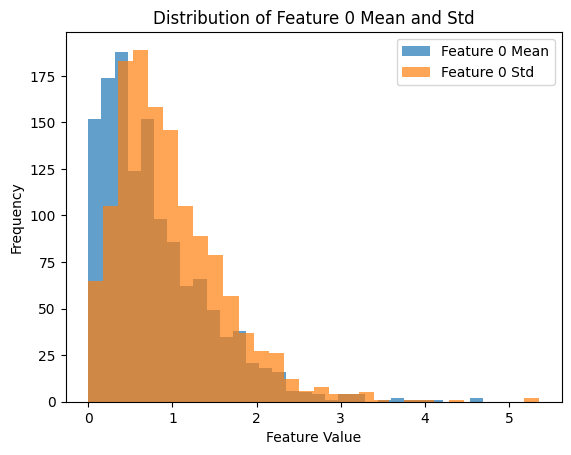

In [40]:
# 12.2 Extract and Analyze Features

# Extract volumetric-like features from the validation set
val_features, val_labels = extract_volumetric_features(model, val_loader, device)

print(f'Extracted Features Shape: {val_features.shape}')
print(f'Labels Shape: {val_labels.shape}')

# Example: Visualize the distribution of a selected feature
import matplotlib.pyplot as plt

feature_index = 0  # Select the first feature
plt.hist(val_features[:, feature_index], bins=30, alpha=0.7, label='Feature 0 Mean')
plt.hist(val_features[:, feature_index + 512], bins=30, alpha=0.7, label='Feature 0 Std')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title(f'Distribution of Feature {feature_index} Mean and Std')
plt.legend()
plt.show()


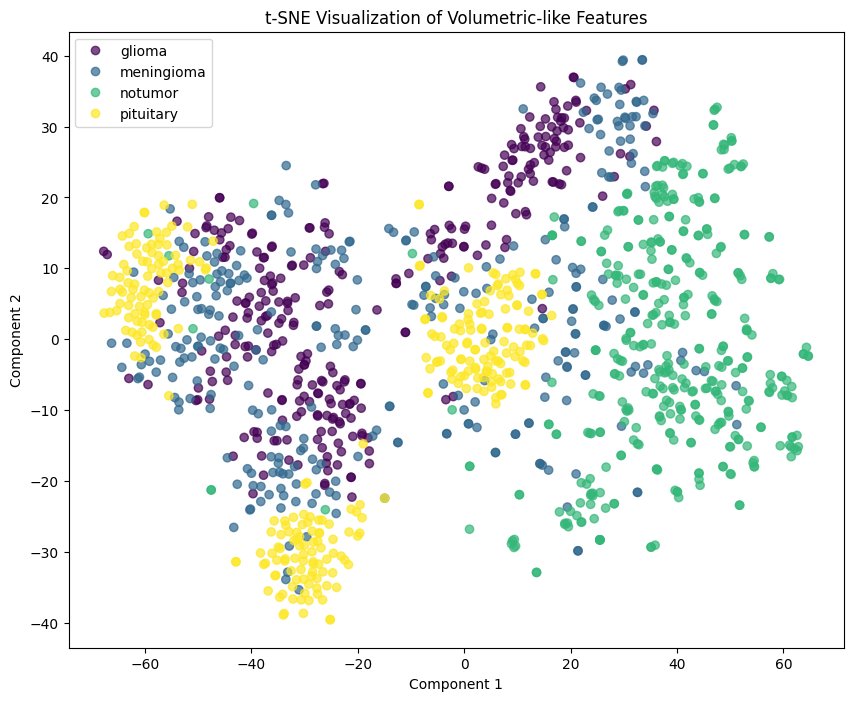

In [41]:
from sklearn.manifold import TSNE

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(val_features)

# Plot the features
plt.figure(figsize=(10,8))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=val_labels, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.title('t-SNE Visualization of Volumetric-like Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


Extracted Features Shape: (1311, 1024)
Labels Shape: (1311,)
Feature vectors and labels saved successfully as NumPy files.


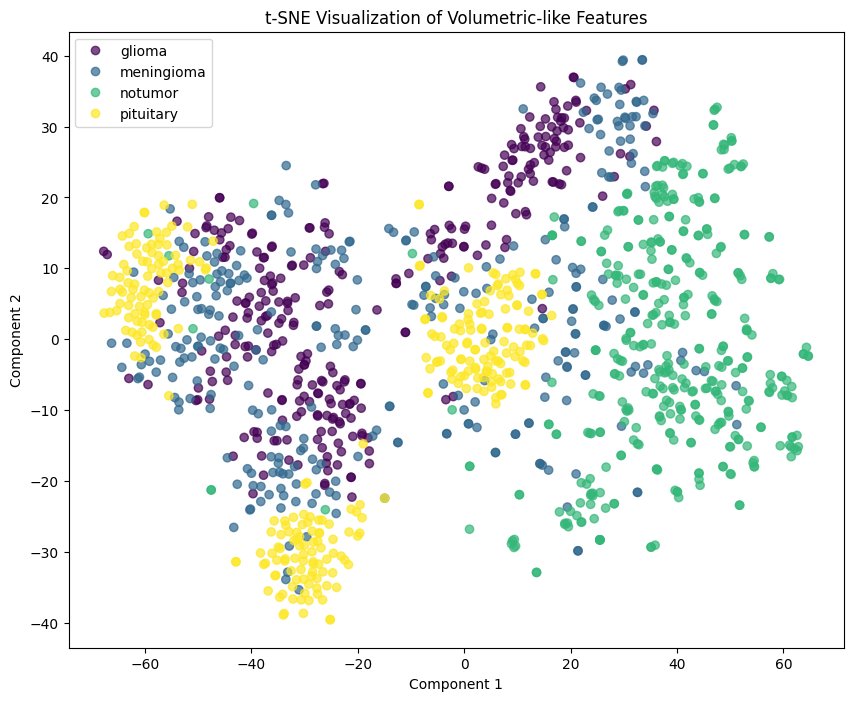

Feature vectors are ready for future fusion with other datasets.


In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

# Assuming you have already defined and trained your model up to feature extraction

# Step 1: Extract Features
val_features, val_labels = extract_volumetric_features(model, val_loader, device)
print(f'Extracted Features Shape: {val_features.shape}')  # e.g., (200, 1024)
print(f'Labels Shape: {val_labels.shape}')               # e.g., (200,)

# Step 2: Save Features as NumPy Files
save_dir = '/content/drive/MyDrive/feature_vectors/'
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, 'val_features.npy'), val_features)
np.save(os.path.join(save_dir, 'val_labels.npy'), val_labels)
print('Feature vectors and labels saved successfully as NumPy files.')

# Step 3: (Optional) Perform t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(val_features)

plt.figure(figsize=(10,8))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=val_labels, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.title('t-SNE Visualization of Volumetric-like Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Step 4: Prepare for Future Fusion
# Example: Load the saved features
loaded_val_features = np.load(os.path.join(save_dir, 'val_features.npy'))
loaded_val_labels = np.load(os.path.join(save_dir, 'val_labels.npy'))

# Example: Load another modality's features (replace with actual paths)
# other_features = np.load('/content/drive/MyDrive/other_modality_features.npy')

# Ensure sample sizes match
# assert loaded_val_features.shape[0] == other_features.shape[0], "Sample sizes do not match!"

# Concatenate features (uncomment when you have other_features)
# fused_features = np.concatenate((loaded_val_features, other_features), axis=1)
# np.save(os.path.join(save_dir, 'fused_features.npy'), fused_features)

print('Feature vectors are ready for future fusion with other datasets.')
